In [47]:
# IDEA IS THAT HALF OF GDP GROWTH CAN BE PRECISELY FORECASTED VIA POPULATION FORECAST
# SO WE DON'T NEED TO FORECAST GDP GROWTH ENTIRELY

In [61]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

In [62]:
YEARS_HISTORY = [i for i in range(1990, 2018, 1)]
YEARS_FORECAST = [i for i in range(2018, 2041, 1)]
YEARS_ALL = YEARS_HISTORY + YEARS_FORECAST

In [82]:
# READ DATASETS FROM WORLDBANK

df_pop = pd.read_csv('population_estimates.csv')
df_gdp = pd.read_csv('gdp.csv')

# CONVERT YEAR-COLUMN-NAMES FROM STRING TO INTEGERS

df_pop.columns = [int(i) if i.isdigit() else i for i in df_pop.columns]
df_pop.head()

# POPULATION DATA SAMPLE BELOW:

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,"88,2058102041107","89,6447342161671","90,9444984065416","92,0636312302324","92,8928810256546","93,3644592182944","94,2417762782683","94,6334458257547","94,6855128574872","94,5636130374136","94,3359977897322","94,5977173267513","94,6187250683932","94,4582200960042","94,182433231449","93,8510717356103","93,6827381393182","93,4365492669836","93,118514821308","92,7013287709092","92,167884202756","91,8822394948944","91,4361946978695","90,8759821306912","90,2631918706709","89,6285864725376","89,3781629139709","89,0248431468845","88,5898874736913","88,0443145798341","87,4813398865699","86,7261782925178","86,0581180690568","84,9067498061564","83,5981421599692","81,9464190070822","80,5768076612983","79,1426598702933","77,675807259833","76,1978668610219","74,7148124657176","73,2195167125996","71,747229015842","70,3090971016106","68,9206181109492","67,60287661057","66,418678595391","65,2754520648483","64,2352931711411","63,3650268619003","62,6947151615853","62,3416961742781","62,1688542533565","62,1181878490802","62,0898579615104","62,0172343927312","62,0574752897263","61,9161803533744","61,6736512566737","61,4388261782302","61,2507977815826","60,8853990063407","60,6265766177788","60,3889352713934","60,0471855237882","59,5532700661876","59,0843495562595","58,4700568882127","57,7790614753412","57,1203361906792","56,552277378621","56,099647590667","55,7075749910587","55,3786633487538","55,0961406363375","54,8521130154695","54,7110232796612","54,5938649678594","54,5137941567587","54,4820837065065","54,5009738006491","54,5976044210336","54,7155643418991","54,8567251239339","55,0176920330375","55,1940982949852","55,3927568740207","55,5886755538545","55,7826187321008","55,9741440370247","56,1626800311708"
1,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,"6,60274556374436","6,71431262352961","6,80904285724775","6,88477814628338","6,93744936707007","6,96551003920138","7,03337839719147","7,0705259637216","7,08547282245419","7,08753023323521","7,08192339573659","7,12104583510089","7,14446158736621","7,15067239890778","7,13679569182097","7,10370679844783","7,08650132308792","7,04985838007843","7,00058869415609","6,94535376255512","6,88863636518661","6,86245269429549","6,82827957766115","6,78995683801753","6,75140025872696","6,71597833714856","6,71873941751862","6,71988711974011","6,72413419156773","6,7347167150005","6,73251809748213","6,78084775154971","6,87209344706523","6,90916114081667","6,94144048296085","6,93159691710332","6,96368353997424","6,98445012923668","6,99704829471308","7,00198947183087","6,99987521925162","6,98657780331697","6,96514402335386","6,93634737723826","6,8994514740317","6,85635667674224","6,81589278771793","6,76820027235243","6,72337243701829","6,69194067195831","6,68053685025314","6,70122843661228","6,73190461250903","6,77647712981945","6,84070435363343","6,92825980542579","7,05099352083727","7,19046177972777","7,34290692759877","7,50161722547518","7,66371458211833","7,84585878807949","8,02659055906073","8,21053570093308","8,40296374282733","8,60695633632512","8,82636992144508","9,04899867910472","9,27736585904191","9,51419106375759","9,76222736021734","10,0175139127664","10,2789280948965","10,5489012487375","10,8286920572129","11,1198770509465","11,4109162653524","11,7069378981572","12,014316308486","12,3399690006757","12,6881860400338","13,0397345312309","13,4046695279119","13,7831961248235","14,1741379146557","14,5769024642415",

In [83]:
df_gdp.columns = [int(i) if i.isdigit() else i for i in df_gdp.columns] 
df_gdp.head()

# GDP DATA SAMPLE BELOW:

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.671232e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.337863e+10,2.535276e+10,2.562037e+10,2.848352e+10,3.006553e+10,3.419659e+10,3.543156e+10,4.287950e+10,4.649566e+10,4.933825e+10,5.646010e+10,5.866237e+10,6.024070e+10,6.102987e+10,6.247428e+10,6.409582e+10
2,Angola,AGO,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.175776e+10,4.217173e+10,3.970963e+10,3.018590e+10,3.059020e+10,3.517873e+10,3.994347e+10,4.284907e+10,4.485918e+10,4.583778e+10,4.723795e+10,4.922478e+10,5.595168e+10,5.849974e+10,6.448915e+10,7.797192e+10,9.277803e+10,1.142929e+11,1.300848e+11,1.332237e+11,1.378237e+11,1.431621e+11,1.505744e+11,1.608778e+11,1.684455e+11,1.734984e+11,1.720870e+11,1.733290e+11
3,Albania,ALB,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.552181e+10,1.092906e+10,1.014217e+10,1.111581e+10,1.203843e+10,1.363954e+10,1.488074e+10,1.326798e+10,1.446328e+10,1.641599e+10,1.751038e+10,1.890076e+10,1.970052e+10,2.083793e+10,2.202769e+10,2.328785e+10,2.455262e+10,2.600122e+10,2.697909e+10,2.788359e+10,2.891809e+10,2.965555e+10,3.007665e+10,3.037764e+10,3.091665e+10,3.160261e+10,3.266198e+10,3.391665e+10
4,Andorra,AND,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# DEFINE INTERESTED COUNTRIES

COUNTRIES = ['European Union',
             'China',
             'United States',
             'India',
             'Latin America & Caribbean',
             'Sub-Saharan Africa',
             'Japan',
             'Middle East & North Africa',
             'Russian Federation',
             'Canada',
             'Australia',
             'World']

# CODES OF AGE GROUPS (25-69 yo). OTHER AGES DON'T PRODUCE VALUE ADDED IN GENERAL, SO NOT INTERESTING TO OBSERVE

CODES = ['SP.POP.2529.', 'SP.POP.3034.', 'SP.POP.3539.', 'SP.POP.4044.', 'SP.POP.4549.', 'SP.POP.5054.', 'SP.POP.5559.', 'SP.POP.6064.', 'SP.POP.6469.']
CODES = [i + 'MA' for i in CODES] + [i + 'FE' for i in CODES]  # male + female

In [85]:
# FORM POPULATION (25-69) DICTIONARY FROM RAW-DATAFRAME

population = {country: {year: 0 for year in YEARS_ALL} for country in COUNTRIES}
for index, row in df_pop.iterrows():
    country = row['Country Name']
    code = row['Indicator Code']
    if country in COUNTRIES and code in CODES:
        for year in YEARS_ALL:
            population[country][year] += float(row[year])

In [86]:
# FORM GDP DICTIONARY FROM RAW-DATAFRAME
gdp = {row['Country Name']: {year: row[year] for year in YEARS_HISTORY} for index, row in df_gdp.iterrows() if row['Country Name'] in COUNTRIES}

# CALC GDP PER CAPITA (25-69 only)
gdp_per_cap = {country: {year: (gdp[country][year] / population[country][year]) for year in YEARS_HISTORY} for country in COUNTRIES}

# CALC PER CAPITA YEARLY GROWTH
gdp_per_cap_growth = {country: {year: gdp_per_cap[country][year] / gdp_per_cap[country][year - 1] for year in YEARS_HISTORY if year != 1990} for country in COUNTRIES}

In [87]:
# FORECAST GROWTH FOR 2018 - 2040

for country in COUNTRIES:
    for year in YEARS_FORECAST:
        if country in ['European Union', 'Australia', 'Canada']:
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'United States':
            gdp_per_cap_growth[country][year] = 1.025
        if country in ['China', 'India']:
            gdp_per_cap_growth[country][year] = (gdp_per_cap_growth[country][year - 1] - 1) * 0.8 + 1.006
        if country == 'Japan':
            gdp_per_cap_growth[country][year] = 1.015
        if country == 'Latin America & Caribbean':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'Middle East & North Africa':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'Russian Federation':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'World':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'Sub-Saharan Africa':
            gdp_per_cap_growth[country][year] = 1.02

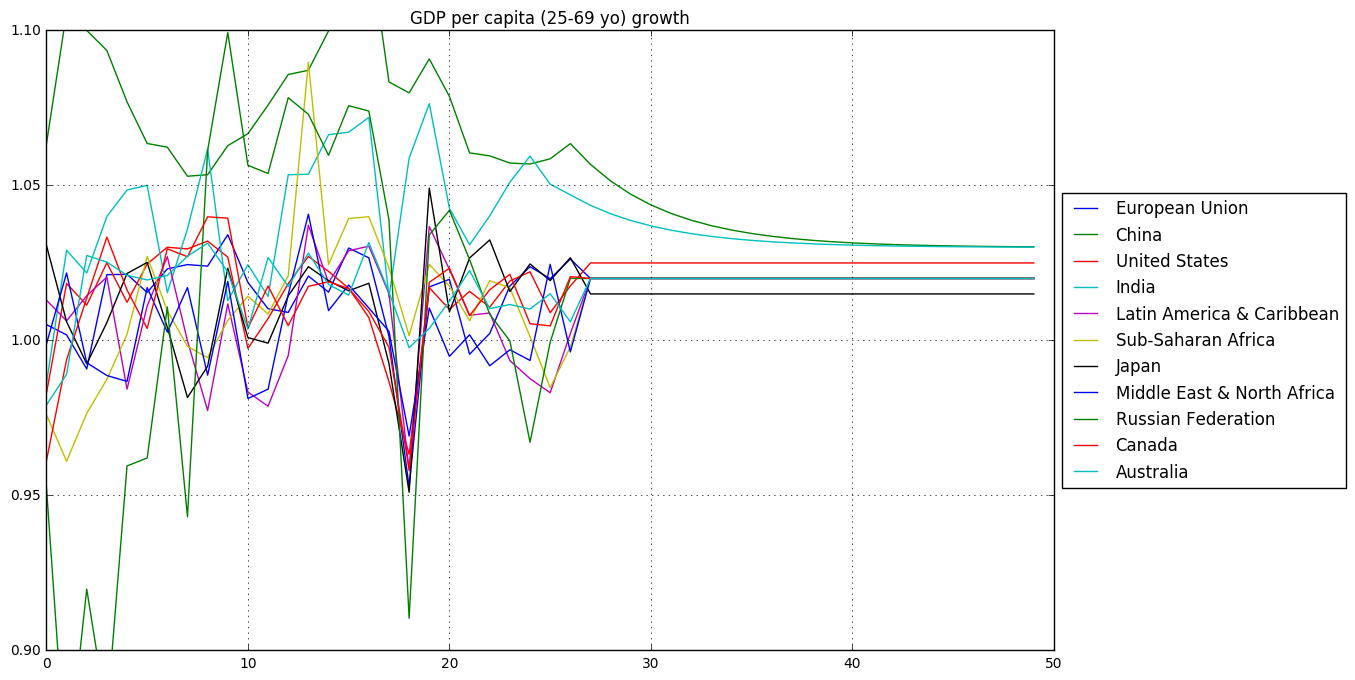

In [88]:
# PLOT GDP PER CAPITA GROWTH

plt.figure(figsize=[13, 8])
[plt.plot(gdp_per_cap_growth[country].values(), label=country) for country in COUNTRIES[:-1]]
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(top=1.1, bottom=0.9)
plt.title('GDP per capita (25-69 yo) growth')
plt.grid()

In [89]:
# CALC GDP PER CAPITA FOR 2018 - 2040 WITH FORECASTED DATA

for country in COUNTRIES:
    for year in YEARS_FORECAST:
        gdp_per_cap[country][year] = gdp_per_cap[country][year - 1] * gdp_per_cap_growth[country][year]

# CALC GDP FOR 2018 - 2040 WITH FORECASTED DATA

gdp = {country: {year: gdp_per_cap[country][year] * population[country][year] for year in YEARS_ALL} for country in COUNTRIES}

In [90]:
gdp['Other'] = dict()
gdp['Other Western'] = dict()

# CALC GDP FOR ALL OTHER COUNTRIES
gdp['Other'] = {year: gdp['World'][year] - sum([gdp[country][year] for country in COUNTRIES[:-1]]) for year in YEARS_ALL}

# SUM GDP FOR AUSTRALIA AND CANADA TO NEW CATEGORY "OTHER WESTERN"
gdp['Other Western'] = {year: gdp['Australia'][year] + gdp['Canada'][year] for year in YEARS_ALL}

del gdp['Australia']
del gdp['Canada']

In [91]:
# NORMALIZE DATA FOR CHART WITH Y=[0;1]

gdp = {country: {year: gdp[country][year] / gdp['World'][year] for year in YEARS_ALL} for country in COUNTRIES[:-3] + ['Other'] + ['Other Western']}

(0.0, 1)

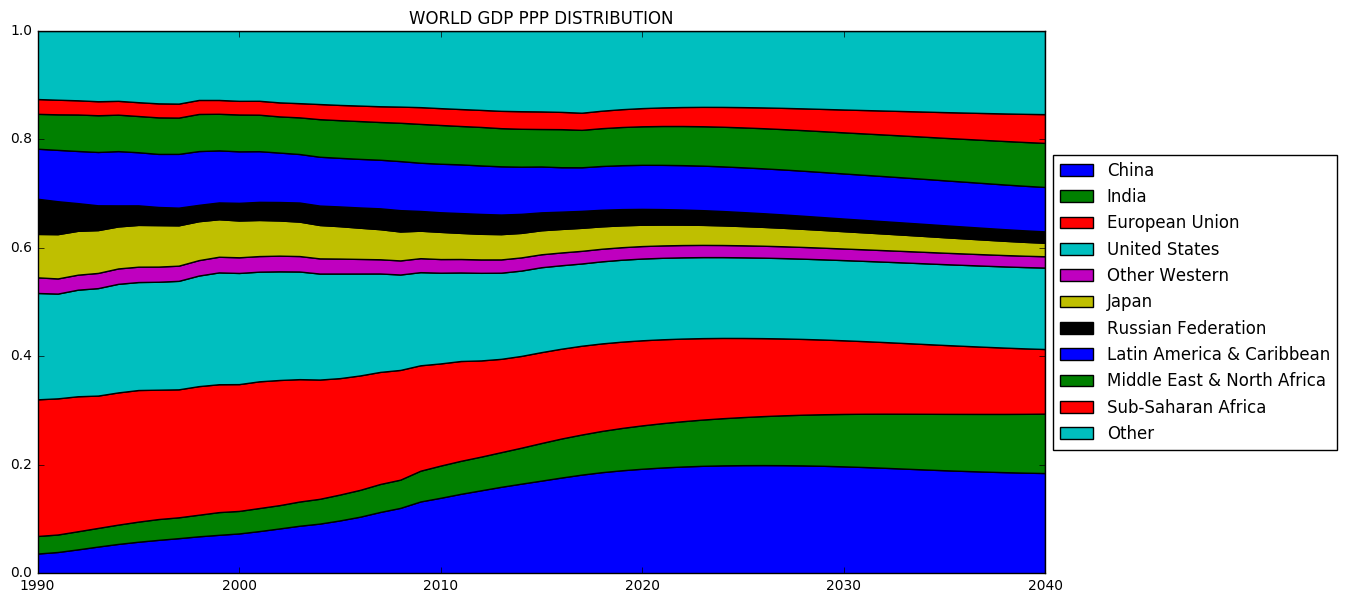

In [92]:
plt.figure(figsize=[13, 7])
plt.stackplot(YEARS_ALL,
              gdp['China'].values(),
              gdp['India'].values(),
              gdp['European Union'].values(),
              gdp['United States'].values(),
              gdp['Other Western'].values(),
              gdp['Japan'].values(),
              gdp['Russian Federation'].values(),
              gdp['Latin America & Caribbean'].values(),
              gdp['Middle East & North Africa'].values(),
              gdp['Sub-Saharan Africa'].values(),
              gdp['Other'].values(),
              labels=['China', 'India', 'European Union', 'United States', 'Other Western', 'Japan', 'Russian Federation', 'Latin America & Caribbean', 'Middle East & North Africa', 'Sub-Saharan Africa', 'Other'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('WORLD GDP PPP DISTRIBUTION')
plt.ylim(top=1)